In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet, ElasticNetCV, HuberRegressor, SGDRegressor
from sklearn.linear_model import RANSACRegressor, HuberRegressor, PoissonRegressor, TweedieRegressor, Lars
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, ExtraTreesRegressor,  VotingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.exceptions import ConvergenceWarning
from sklearn.cluster import KMeans
from sklearn.exceptions import NotFittedError
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings("ignore", category= ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
import numpy as np

## Bước 1: Tiền xử lý và gán nhãn 

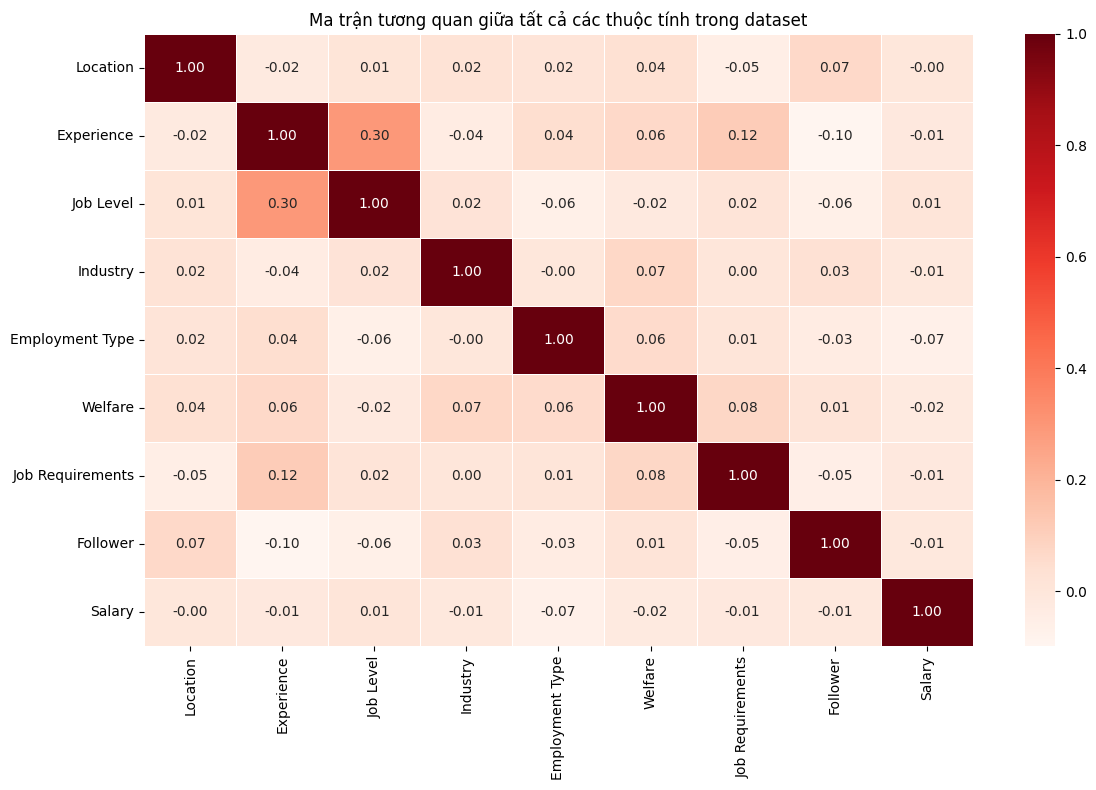

Dữ liệu đã được tiền xử lý xong!


In [ ]:
# Kĩ hơn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# 1. Đọc dữ liệu
data = pd.read_csv('Defined_salary.csv')

# 2. Xử lý dữ liệu thiếu
# Loại bỏ các dòng có giá trị thiếu (NaN)
data.dropna(inplace=True)  # Bạn cũng có thể sử dụng data.fillna() nếu muốn thay thế giá trị thiếu

# 3. Chuyển đổi kiểu dữ liệu cho các cột phân loại
label_encoder = LabelEncoder()

# Mã hóa các cột phân loại (categorical columns)
categorical_columns = ['Location', 'Job Level', 'Employment Type']
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])

# 4. Tách các danh sách trong các cột thành đặc trưng nhị phân
# Cột 'Industry', 'Welfare', 'Job Requirements' chứa danh sách (chuỗi)
# Ta sẽ đếm số lượng phần tử trong các danh sách này để chuyển thành các đặc trưng
data['Industry'] = data['Industry'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)
data['Welfare'] = data['Welfare'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)
data['Job Requirements'] = data['Job Requirements'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

# 5. Chuẩn hóa dữ liệu
scaler = MinMaxScaler()

# Các cột cần chuẩn hóa (các cột số liên tục)
columns_to_scale = ['Experience', 'Follower', 'Salary']
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# 6. Tính toán ma trận tương quan giữa các thuộc tính
correlation_matrix = data.corr()

# 7. Vẽ biểu đồ heatmap cho ma trận tương quan
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', fmt='.2f', linewidths=0.5, cbar=True)
plt.title("Ma trận tương quan giữa tất cả các thuộc tính trong dataset")
plt.tight_layout()
plt.show()

# 8. Phân chia tập dữ liệu thành tập huấn luyện và kiểm tra
X = data.drop('Salary', axis=1)  # Dữ liệu đầu vào (tất cả các cột trừ 'Salary')
y = data['Salary']  # Nhãn đầu ra (cột 'Salary')

# Chia tập dữ liệu thành 80% huấn luyện và 20% kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dữ liệu đã được tiền xử lý xong!")

In [ ]:
# Hàm huấn luyện và đánh giá mô hình (có phân cụm)
def train_and_evaluate(models_dict, X_train, y_train, X_test, y_test):
    results = {}
    for model_name, model_info in models_dict.items():
        try:
            grid_search = GridSearchCV(
                estimator=model_info["model"],
                param_grid=model_info["params"],
                cv=3,
                scoring="neg_mean_absolute_error",  # Mặc định sử dụng MAE cho hồi quy
                verbose=0,
                n_jobs=-1,
                error_score='raise'
            )
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            # Kiểm tra nếu mô hình là phân cụm (DBSCAN hoặc GaussianMixture)
            if isinstance(best_model, (DBSCAN, GaussianMixture)):
                try:
                    # DBSCAN không có phương thức `predict()`, thay vào đó sử dụng `labels_`
                    if isinstance(best_model, DBSCAN):
                        y_pred = best_model.fit_predict(X_test)
                    else:
                        y_pred = best_model.predict(X_test)

                    # Tính toán Silhouette Score và Davies-Bouldin Index cho phân cụm
                    silhouette = silhouette_score(X_test, y_pred)
                    davies_bouldin = davies_bouldin_score(X_test, y_pred)
                    results[model_name] = {"Silhouette": silhouette, "Davies-Bouldin": davies_bouldin}
                    print(f"{model_name}: Silhouette={silhouette}, Davies-Bouldin={davies_bouldin}")
                except Exception as e:
                    print(f"Error in {model_name} evaluation: {e}")
            else:
                # Mô hình hồi quy
                y_pred = best_model.predict(X_test)
                mae = mean_absolute_error(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                r2 = r2_score(y_test, y_pred)
                results[model_name] = {"MAE": mae, "RMSE": rmse, "R²": r2}
                print(f"{model_name}: MAE={mae}, RMSE={rmse}, R²={r2}")
        except Exception as e:
            print(f"Error in {model_name}: {e}")
    return results

In [ ]:
# # Hàm huấn luyện và đánh giá mô hình (KO có phân cụm)
# def train_and_evaluate(models_dict, X_train, y_train, X_test, y_test):
#     results = {}
#     for model_name, model_info in models_dict.items():
#         try:
#             grid_search = GridSearchCV(
#                 estimator=model_info["model"],
#                 param_grid=model_info["params"],
#                 cv=3,
#                 scoring="neg_mean_absolute_error",
#                 verbose=0,
#                 n_jobs=-1,
#                 error_score='raise'
#             )
#             grid_search.fit(X_train, y_train)

#             best_model = grid_search.best_estimator_
#             y_pred = best_model.predict(X_test)

#             mae = mean_absolute_error(y_test, y_pred)
#             rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#             r2 = r2_score(y_test, y_pred)

#             results[model_name] = {"MAE": mae, "RMSE": rmse, "R²": r2}
#             print(f"{model_name}: MAE={mae}, RMSE={rmse}, R²={r2}")
#         except Exception as e:
#             print(f"Error in {model_name}: {e}")
#     return results

In [ ]:
# Đoạn 1
models_part_1 = {
    "Linear Regression": {"model": LinearRegression(), "params": {}},
    "Ridge Regression": {"model": Ridge(), "params": {"alpha": [0.1, 1.0, 10.0]}},
    "Lasso Regression": {"model": Lasso(), "params": {"alpha": [0.01, 0.1, 1.0]}},
    "ElasticNet Regression": {"model": ElasticNet(), "params": {"alpha": [0.01, 0.1, 1.0], "l1_ratio": [0.2, 0.5, 0.8]}},
    "Support Vector Regression (SVR)": {"model": SVR(), "params": {"kernel": ["linear", "rbf"], "C": [0.1, 1.0, 10.0]}},
    "KNeighbors Regressor": {"model": KNeighborsRegressor(), "params": {"n_neighbors": [3, 5, 7], "weights": ["uniform", "distance"]}},
    "Gradient Boosting Regressor": {
        "model": GradientBoostingRegressor(),
        "params": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2], "max_depth": [3, 5, 7]}
    }
}
print("Dò tìm tham số và đánh giá hiệu suất các mô hình (Phần 1):")
model_results_part_1 = train_and_evaluate(models_part_1, X_train, y_train, X_test, y_test)

Dò tìm tham số và đánh giá hiệu suất các mô hình (Phần 1):
Linear Regression: MAE=0.0007064781513528993, RMSE=0.001409534643827769, R²=-1626.3774853503685
Ridge Regression: MAE=0.0006780833331954349, RMSE=0.0013598180705518108, R²=-1513.6015977392324
Lasso Regression: MAE=0.000344641550006292, RMSE=0.00034574509989540586, R²=-96.91491736459088
ElasticNet Regression: MAE=0.000344641550006292, RMSE=0.00034574509989540586, R²=-96.91491736459088
Support Vector Regression (SVR): MAE=0.09709185852754428, RMSE=0.0971737001486474, R²=-7734535.159823761
KNeighbors Regressor: MAE=0.0008852844545784088, RMSE=0.015337572389533262, R²=-192684.9485344651
Gradient Boosting Regressor: MAE=0.0010379683508083628, RMSE=0.029131623125593545, R²=-695129.2049506124


In [6]:
# Đoạn 2
models_part_2 = {
    "XGBoost Regressor": {
        "model": xgb.XGBRegressor(),
        "params": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2], "max_depth": [3, 5, 7]}
    }
}
print("Dò tìm tham số và đánh giá hiệu suất mô hình (Phần 2):")
model_results_part_2 = train_and_evaluate(models_part_2, X_train, y_train, X_test, y_test)

Dò tìm tham số và đánh giá hiệu suất mô hình (Phần 2):
XGBoost Regressor: MAE=0.0013374248392274077, RMSE=0.02741677822043666, R²=-615699.678488013


In [7]:
# Đoạn 3
models_part_3 = {
    "Random Forest Regressor": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [10, 20, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    }
}
print("Dò tìm tham số và đánh giá hiệu suất mô hình (Phần 3):")
model_results_part_3 = train_and_evaluate(models_part_3, X_train, y_train, X_test, y_test)

Dò tìm tham số và đánh giá hiệu suất mô hình (Phần 3):
Random Forest Regressor: MAE=0.000659755047070718, RMSE=0.007377409969628554, R²=-44579.46876635139


In [8]:
# Đoạn 4
models_part_4 = {
    "Decision Tree Regressor": {"model": DecisionTreeRegressor(), "params": {"max_depth": [3, 5, 7, 10, None], "min_samples_split": [2, 5, 10, 15]}},
    "AdaBoost Regressor": {"model": AdaBoostRegressor(), "params": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.5, 1.0]}}
}
print("Dò tìm tham số và đánh giá hiệu suất các mô hình (Phần 4):")
model_results_part_4 = train_and_evaluate(models_part_4, X_train, y_train, X_test, y_test)

Dò tìm tham số và đánh giá hiệu suất các mô hình (Phần 4):
Decision Tree Regressor: MAE=0.0008785953400951165, RMSE=0.028615816820878923, R²=-670731.0954369087
AdaBoost Regressor: MAE=0.0015675181374422537, RMSE=0.018271907922069314, R²=-273465.7883879861


In [9]:
# Đoạn 5
models_part_5 = {
    "Huber Regressor": {
        "model": HuberRegressor(),
        "params": {"epsilon": [1.35, 1.5, 1.75, 2.0, 2.5], "alpha": [0.1, 1.0, 10.0], "max_iter": [1000, 5000, 10000]}
    },
    "Bagging Regressor": {
        "model": BaggingRegressor(),
        "params": {"n_estimators": [50, 100, 200], "max_samples": [0.5, 0.75, 1.0]}
    }
}
print("Dò tìm tham số và đánh giá hiệu suất các mô hình (Phần 5):")
model_results_part_5 = train_and_evaluate(models_part_5, X_train, y_train, X_test, y_test)

Dò tìm tham số và đánh giá hiệu suất các mô hình (Phần 5):
Huber Regressor: MAE=1.320765865256614e-05, RMSE=3.440837487188667e-05, R²=0.030238102423633118
Bagging Regressor: MAE=0.0007138603783536505, RMSE=0.010871945470981761, R²=-96815.93398804717


In [10]:
# Đoạn 6
models_part_6 = {
    "LinearSVR": {
        "model": LinearSVR(),
        "params": {"C": [0.01, 0.1], "epsilon": [0.00001, 0.1], "max_iter": [1000, 5000]}
    }
}
print("Dò tìm tham số và đánh giá hiệu suất mô hình (Phần 6):")
model_results_part_6 = train_and_evaluate(models_part_6, X_train, y_train, X_test, y_test)

Dò tìm tham số và đánh giá hiệu suất mô hình (Phần 6):
LinearSVR: MAE=1.9368636000338994e-05, RMSE=3.7653099347210675e-05, R²=-0.16128349771624206


In [11]:
models_part_7 = {
    "K-Means Clustering": {
        "model": KMeans(),
        "params": {
            "n_clusters": [2, 3, 4, 5],
            "init": ["k-means++", "random"],
            "max_iter": [100, 300, 500]
        }
    },
    "SGD Regressor": {
        "model": SGDRegressor(),
        "params": {"penalty": ["l2", "l1", "elasticnet"], "alpha": [0.0001, 0.001, 0.01], "max_iter": [1000, 2000]}  # Các siêu tham số cho SGD
    },
        "HistGradientBoosting Regressor": {
        "model": HistGradientBoostingRegressor(),
        "params": {"learning_rate": [0.01, 0.1, 0.2], "max_depth": [3, 5, 7], "min_samples_leaf": [20, 30, 50]}  # Các tham số cho HistGradientBoosting
    },
    "ExtraTrees Regressor": {
        "model": ExtraTreesRegressor(),
        "params": {"n_estimators": [50, 100, 200], "max_depth": [3, 5, 7], "min_samples_split": [2, 5, 10], "min_samples_leaf": [1, 2, 4]}  # Các tham số cho ExtraTrees
    },
    "MLP Regressor": {
        "model": MLPRegressor(),
        "params": {"hidden_layer_sizes": [(50,), (100,), (50, 50)], "activation": ["relu", "tanh"], "solver": ["adam"], "max_iter": [1000, 2000]}  # Các tham số cho MLP
    }
}
print("Dò tìm tham số và đánh giá hiệu suất mô hình (Phần 7):")
model_results_part_7 = train_and_evaluate(models_part_7, X_train, y_train, X_test, y_test)

Dò tìm tham số và đánh giá hiệu suất mô hình (Phần 7):
K-Means Clustering: MAE=0.26945709025536707, RMSE=0.5190575120625308, R²=-220682428.1280664
SGD Regressor: MAE=10270468694.473213, RMSE=11672168233.773476, R²=-1.1159374984728819e+29
HistGradientBoosting Regressor: MAE=0.00037112608488976747, RMSE=0.0017584071630104183, R²=-2531.652951572285
ExtraTrees Regressor: MAE=0.0003615563474816449, RMSE=0.0016884663271150937, R²=-2334.186666182191
MLP Regressor: MAE=0.011513651229069576, RMSE=0.01932170592431238, R²=-305792.1340392618


In [12]:
models_part_8 = {
    "LightGBM Regressor": {
        "model": LGBMRegressor(verbose=-1),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [-1, 5, 10]
        }
    }
}
print("Dò tìm tham số và đánh giá hiệu suất mô hình (Phần 8):")
model_results_part_8 = train_and_evaluate(models_part_8, X_train, y_train, X_test, y_test)

Dò tìm tham số và đánh giá hiệu suất mô hình (Phần 8):
LightGBM Regressor: MAE=0.00038684520799007875, RMSE=0.00163104476265638, R²=-2178.056817485186


In [13]:
models_part_9 = {
    "ElasticNetCV": {
        "model": ElasticNetCV(),
        "params": {"l1_ratio": [0.1, 0.5, 0.9], "eps": [0.001, 0.01, 0.1]}  # Các tham số cho ElasticNetCV
    },
    "HistGradientBoosting Regressor": {
        "model": HistGradientBoostingRegressor(),
        "params": {"learning_rate": [0.01, 0.1, 0.2], "max_depth": [3, 5, 7], "min_samples_leaf": [20, 30, 50]}  # Các tham số cho HistGradientBoosting
    },
    "ExtraTrees Regressor": {
        "model": ExtraTreesRegressor(),
        "params": {"n_estimators": [50, 100, 200], "max_depth": [3, 5, 7], "min_samples_split": [2, 5, 10], "min_samples_leaf": [1, 2, 4]}  # Các tham số cho ExtraTrees
    },
    "MLP Regressor": {
        "model": MLPRegressor(),
        "params": {"hidden_layer_sizes": [(50,), (100,), (50, 50)], "activation": ["relu", "tanh"], "solver": ["adam"], "max_iter": [1000, 2000]}  # Các tham số cho MLP
    }
}
print("Dò tìm tham số và đánh giá hiệu suất các mô hình (Phần 9):")
model_results_part_9 = train_and_evaluate(models_part_9, X_train, y_train, X_test, y_test)

Dò tìm tham số và đánh giá hiệu suất các mô hình (Phần 9):
ElasticNetCV: MAE=0.000344641550006292, RMSE=0.00034574509989540586, R²=-96.91491736459088
HistGradientBoosting Regressor: MAE=0.00037112608488976747, RMSE=0.0017584071630104183, R²=-2531.652951572285
ExtraTrees Regressor: MAE=0.0004350213483378711, RMSE=0.002870290338473167, R²=-6747.2078779314725
MLP Regressor: MAE=0.014106742627775979, RMSE=0.021803384197831906, R²=-389388.83434586675


In [14]:
models_part_10 = {
    "RANSAC Regressor": {
        "model": RANSACRegressor(),
        "params": {"min_samples": [0.5, 0.8, 1.0], "residual_threshold": [1.0, 5.0, 10.0]}  # Các tham số cho RANSAC
    },
    "Poisson Regressor": {
        "model": PoissonRegressor(),
        "params": {"alpha": [0.1, 1, 10], "max_iter": [100, 200, 300]}  # Các tham số cho Poisson
    },
    "RidgeCV": {
        "model": RidgeCV(),
        "params": {"alphas": [0.1, 1, 10], "store_cv_results": [True, False]}
    },
    "Voting Regressor": {
        "model": VotingRegressor(estimators=[
            ('lr', LinearRegression()),
            ('ridge', Ridge(alpha=1.0)),
            ('lasso', Lasso(alpha=0.1)),
            ('svr', SVR(C=1.0, kernel='rbf')),
            ('dt', DecisionTreeRegressor(max_depth=5)),
            ('knn', KNeighborsRegressor(n_neighbors=5))
        ]),
        "params": {}
    },
    # Thêm Stacking Regressor
    "Stacking Regressor": {
        "model": StackingRegressor(
            estimators=[
                ('lr', LinearRegression()),
                ('ridge', Ridge(alpha=1.0)),
                ('lasso', Lasso(alpha=0.1)),
                ('svr', SVR(C=1.0, kernel='rbf')),
                ('dt', DecisionTreeRegressor(max_depth=5)),
                ('knn', KNeighborsRegressor(n_neighbors=5))
            ],
            final_estimator=LinearRegression()
        ),
        "params": {}
    }
}
print("Dò tìm tham số và đánh giá hiệu suất các mô hình (Phần 10):")
model_results_part_10 = train_and_evaluate(models_part_10, X_train, y_train, X_test, y_test)

Dò tìm tham số và đánh giá hiệu suất các mô hình (Phần 10):
RANSAC Regressor: MAE=0.0007064781513528913, RMSE=0.0014095346438277642, R²=-1626.3774853503578
Poisson Regressor: MAE=0.0002898801682604707, RMSE=0.0002934943904647702, R²=-69.55639847480903
RidgeCV: MAE=0.0006780833331751668, RMSE=0.0013598180705457167, R²=-1513.6015977256573
Voting Regressor: MAE=0.016937946852599136, RMSE=0.017539179410851605, R²=-251972.77087048622
Stacking Regressor: MAE=0.00045874104621711307, RMSE=0.0006804775817423788, R²=-378.283926407389


In [15]:
# models_part_9 = {
#     # "DBSCAN": {
#     #     "model": DBSCAN(),
#     #     "params": {"eps": [0.3, 0.5, 0.7], "min_samples": [5, 10, 15]}
#     # },
#     "Gaussian Mixture Models": {
#         "model": GaussianMixture(),
#         "params": {"n_components": [2, 3, 4], "covariance_type": ['full', 'tied']}
#     }
# }
# print("Dò tìm tham số và đánh giá hiệu suất các mô hình (Phần 9):")
# model_results_part_9 = train_and_evaluate(models_part_9, X_train, y_train, X_test, y_test)

## Bước 3: Vẽ biểu đồ so sánh hiệu suất 

In [16]:
import matplotlib.pyplot as plt
# Hàm vẽ biểu đồ dự đoán theo bố cục 3x3
def plot_predictions_grid(models_dict, X_test, y_test, title_prefix=""):
    models = list(models_dict.items())
    num_models = len(models)
    num_rows = (num_models // 3) + (1 if num_models % 3 != 0 else 0)  # Tính số hàng cần thiết (3 cột mỗi hàng)
    fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows))  # Kích thước linh hoạt
    axes = axes.flatten()  # Chuyển mảng 2D thành 1D để dễ thao tác
    
    for idx, (model_name, model_info) in enumerate(models):
        ax = axes[idx]
        try:
            # Lấy mô hình tốt nhất
            grid_search = GridSearchCV(
                estimator=model_info["model"],
                param_grid=model_info["params"],
                cv=3,
                scoring="neg_mean_absolute_error",
                verbose=0,
                n_jobs=-1,
                error_score='raise'
            )
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            
            # Dự đoán
            y_pred = best_model.predict(X_test)

            # Vẽ biểu đồ
            ax.scatter(y_test, y_pred, alpha=0.6, label="Dự đoán")
            ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label="Đường tham chiếu")
            ax.set_title(f"{title_prefix} - {model_name}", fontsize=10)
            ax.set_xlabel("Giá trị thực", fontsize=8)
            ax.set_ylabel("Giá trị dự đoán", fontsize=8)
            ax.legend(fontsize=8)
            ax.grid(True)
        except Exception as e:
            ax.set_title(f"Error in {model_name}", fontsize=10)
            ax.axis('off')

    # Ẩn các ô thừa
    for i in range(len(models), len(axes)):
        axes[i].axis('off')

    fig.suptitle(f"{title_prefix}: Biểu đồ dự đoán của các mô hình", fontsize=16, y=0.95)
    plt.subplots_adjust(top=0.9, hspace=0.4)  # Điều chỉnh khoảng cách tiêu đề và các biểu đồ
    plt.tight_layout(rect=[0, 0, 1, 0.92])  # Giữ khoảng cách hợp lý để tiêu đề không chèn vào biểu đồ
    plt.show()

Vẽ biểu đồ dự đoán (Phần 1):


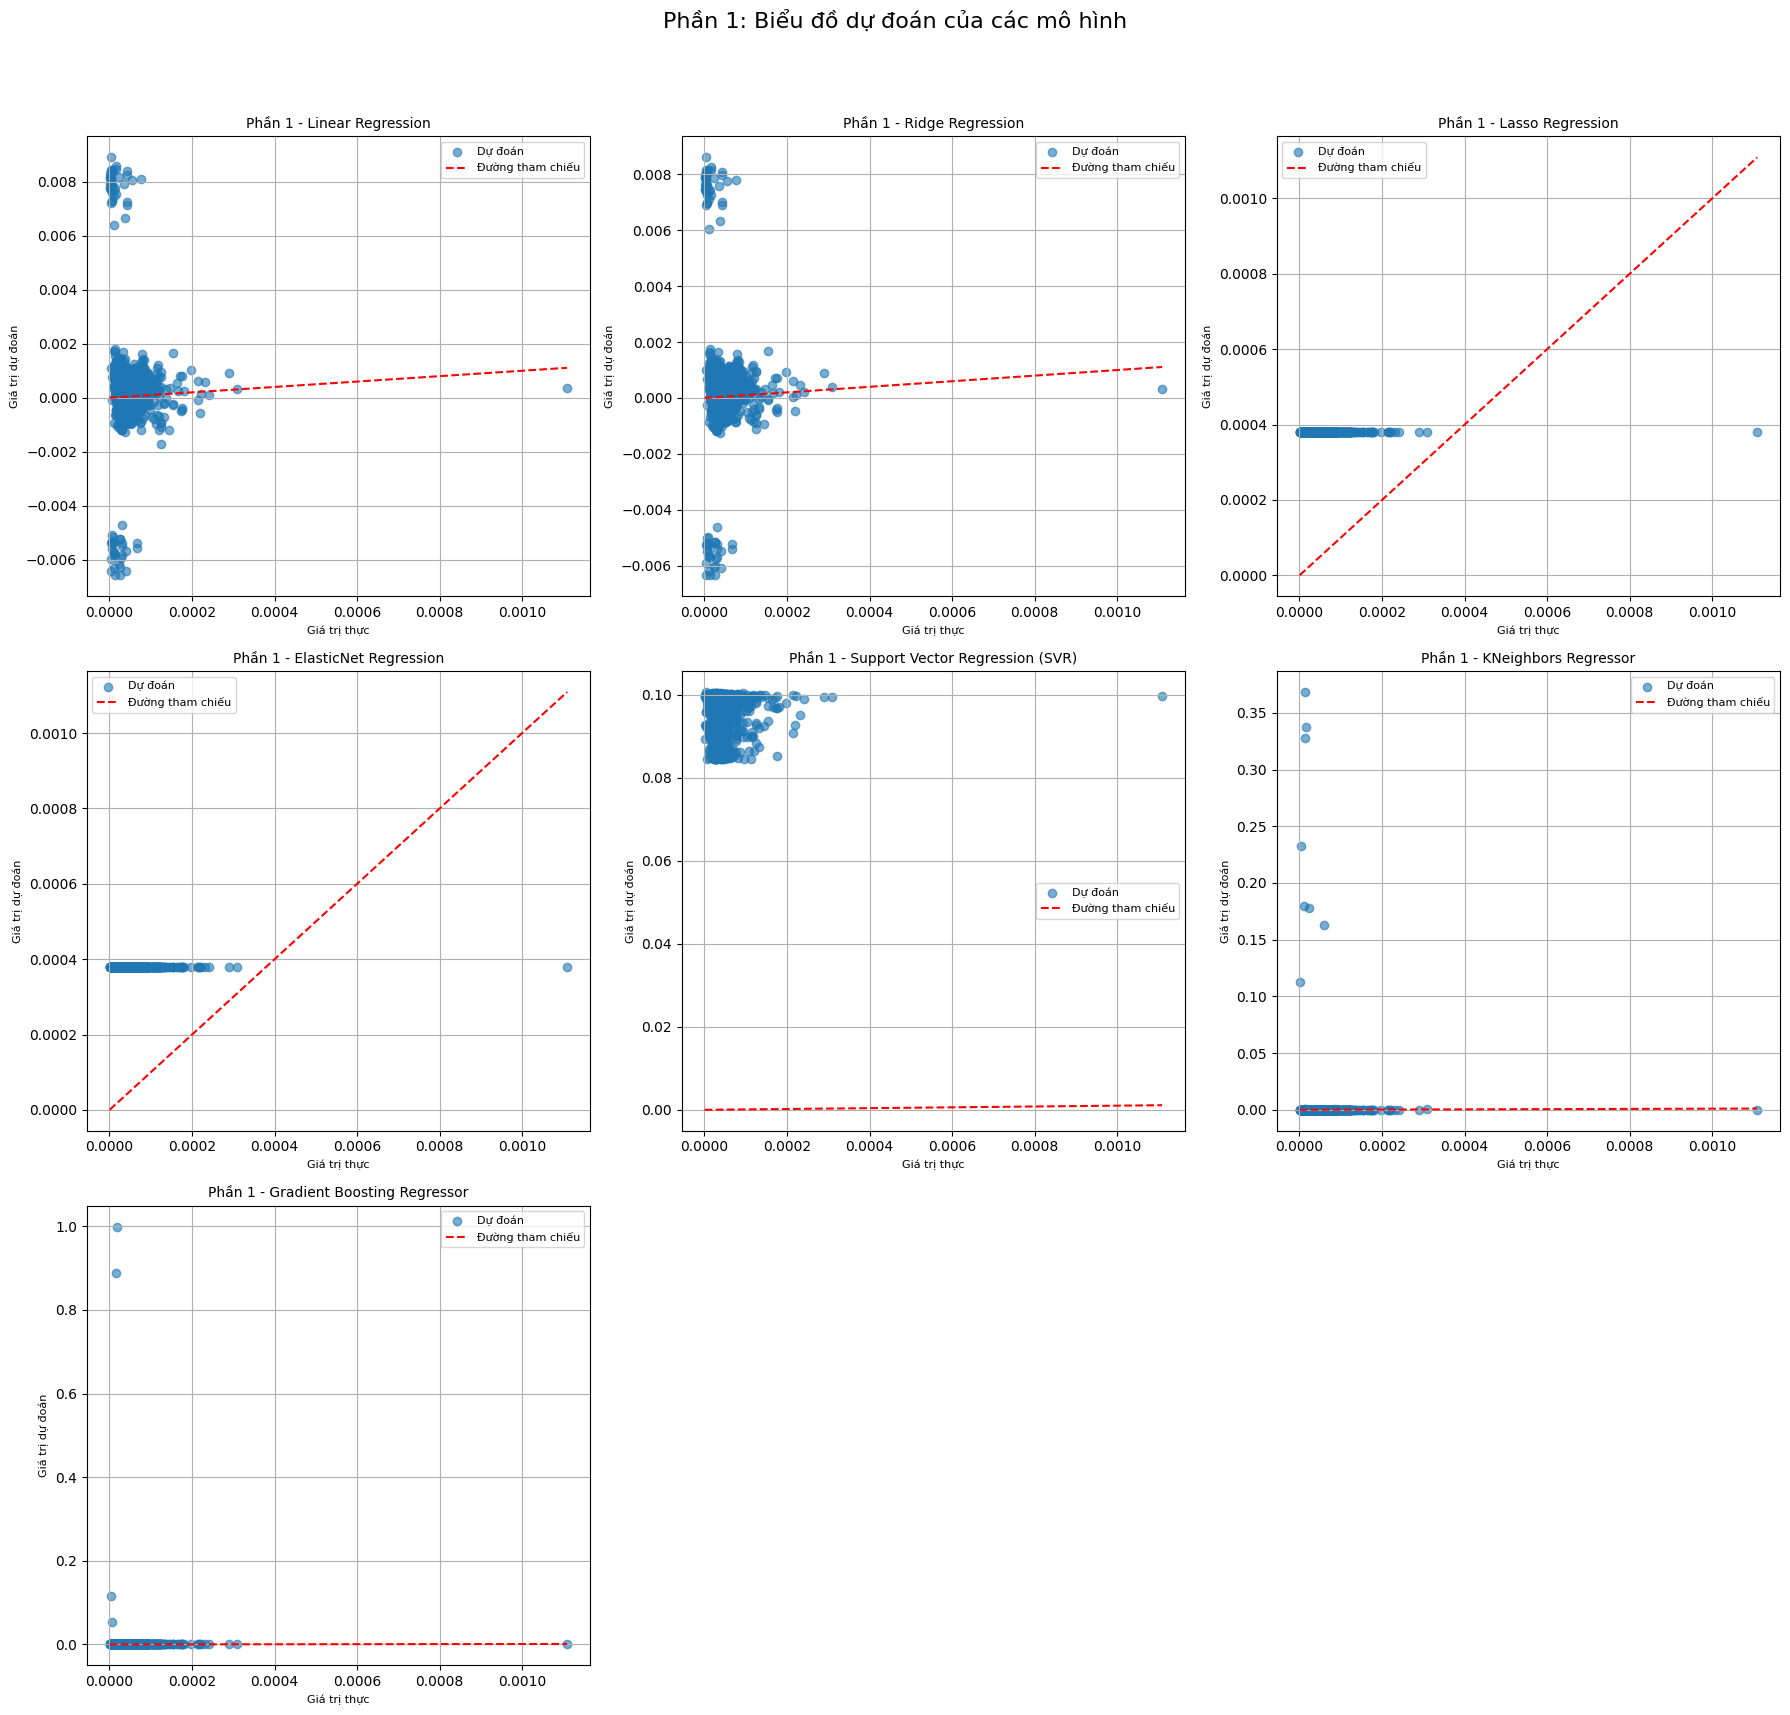

In [17]:
# Vẽ biểu đồ cho từng nhóm
print("Vẽ biểu đồ dự đoán (Phần 1):")
plot_predictions_grid(models_part_1, X_test, y_test, title_prefix="Phần 1")

Vẽ biểu đồ dự đoán (Phần 2):


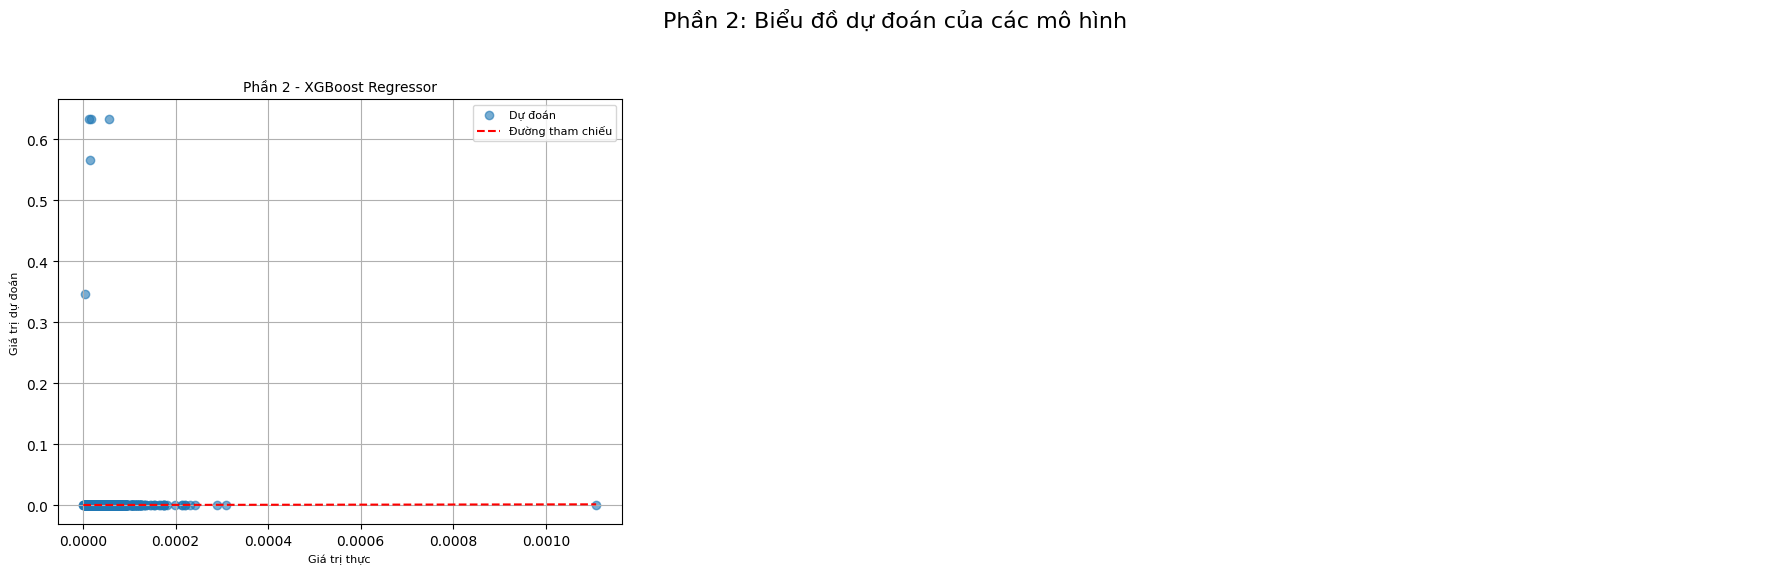

In [18]:
# Vẽ biểu đồ cho từng nhóm
print("Vẽ biểu đồ dự đoán (Phần 2):")
plot_predictions_grid(models_part_2, X_test, y_test, title_prefix="Phần 2")

Vẽ biểu đồ dự đoán (Phần 3):


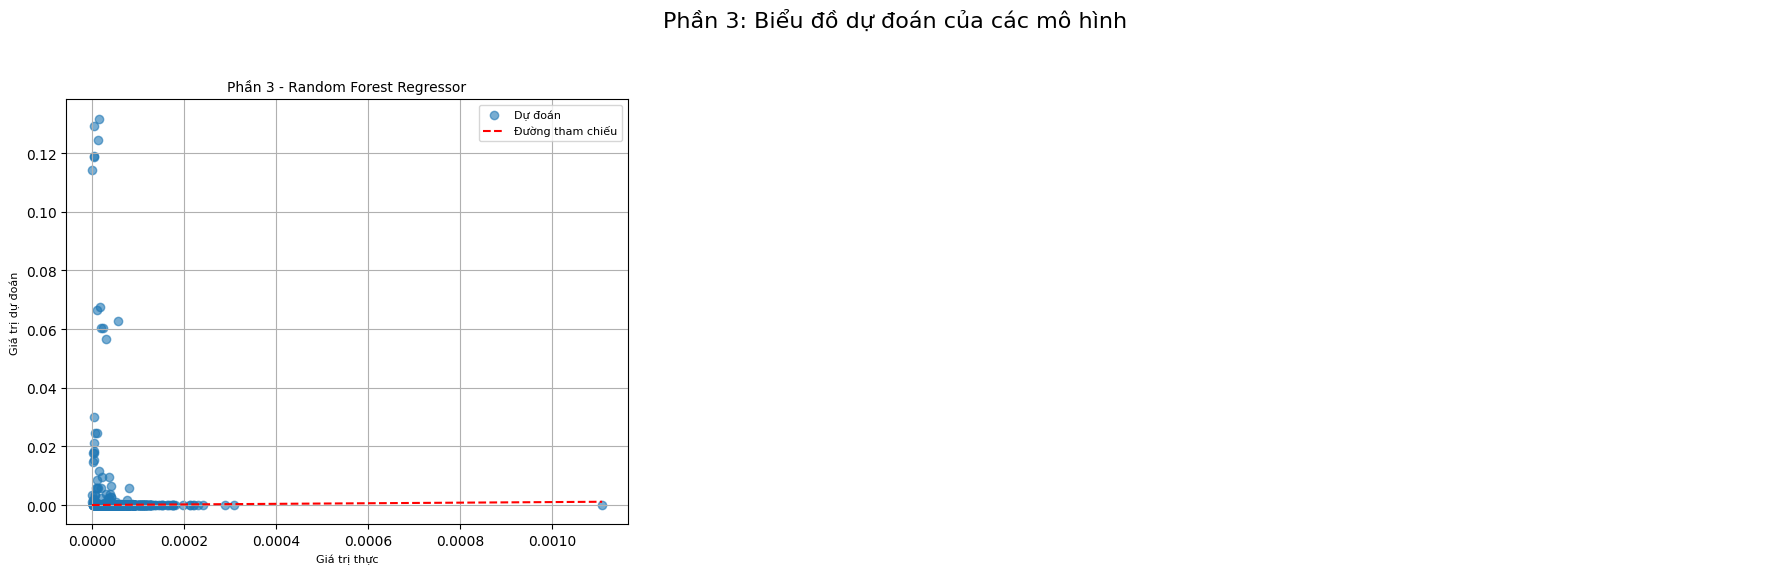

In [19]:
# Vẽ biểu đồ cho từng nhóm
print("Vẽ biểu đồ dự đoán (Phần 3):")
plot_predictions_grid(models_part_3, X_test, y_test, title_prefix="Phần 3")

Vẽ biểu đồ dự đoán (Phần 4):


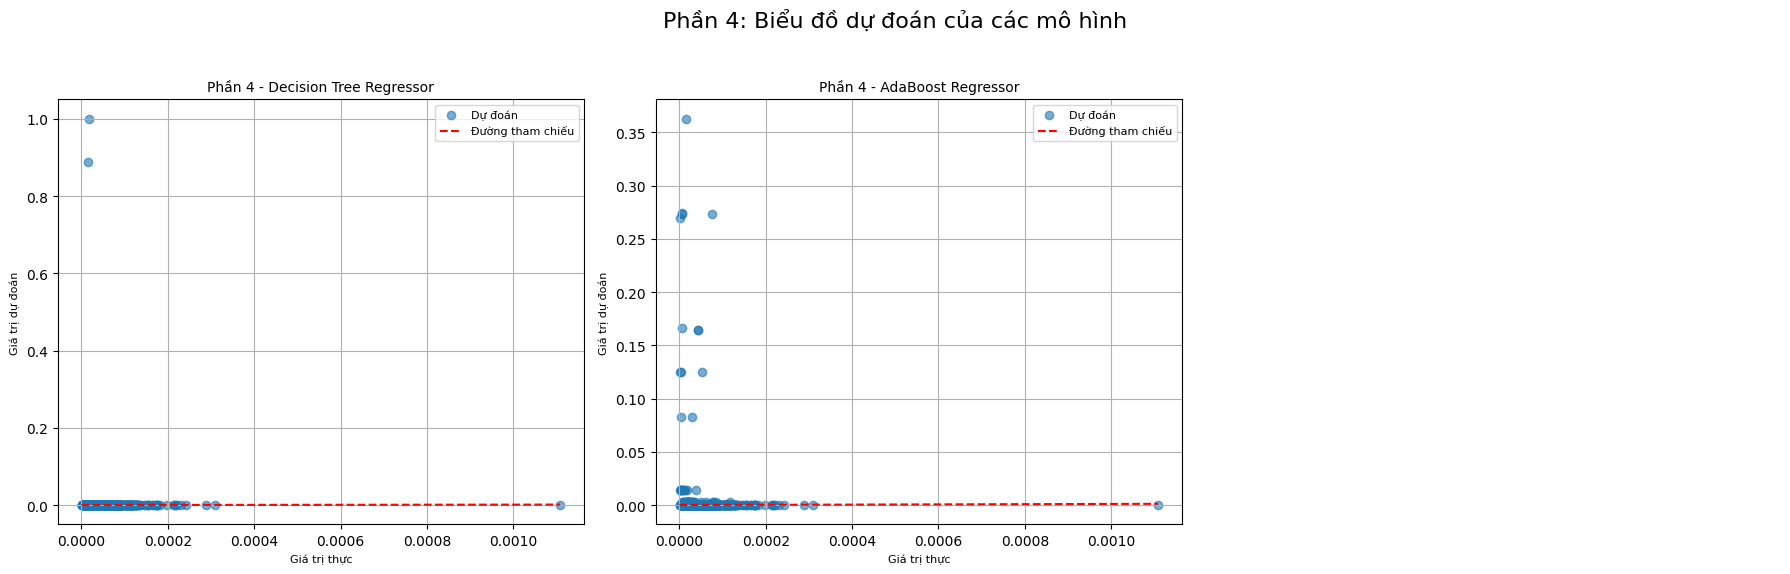

In [20]:
# Vẽ biểu đồ cho từng nhóm
print("Vẽ biểu đồ dự đoán (Phần 4):")
plot_predictions_grid(models_part_4, X_test, y_test, title_prefix="Phần 4")

Vẽ biểu đồ dự đoán (Phần 5):


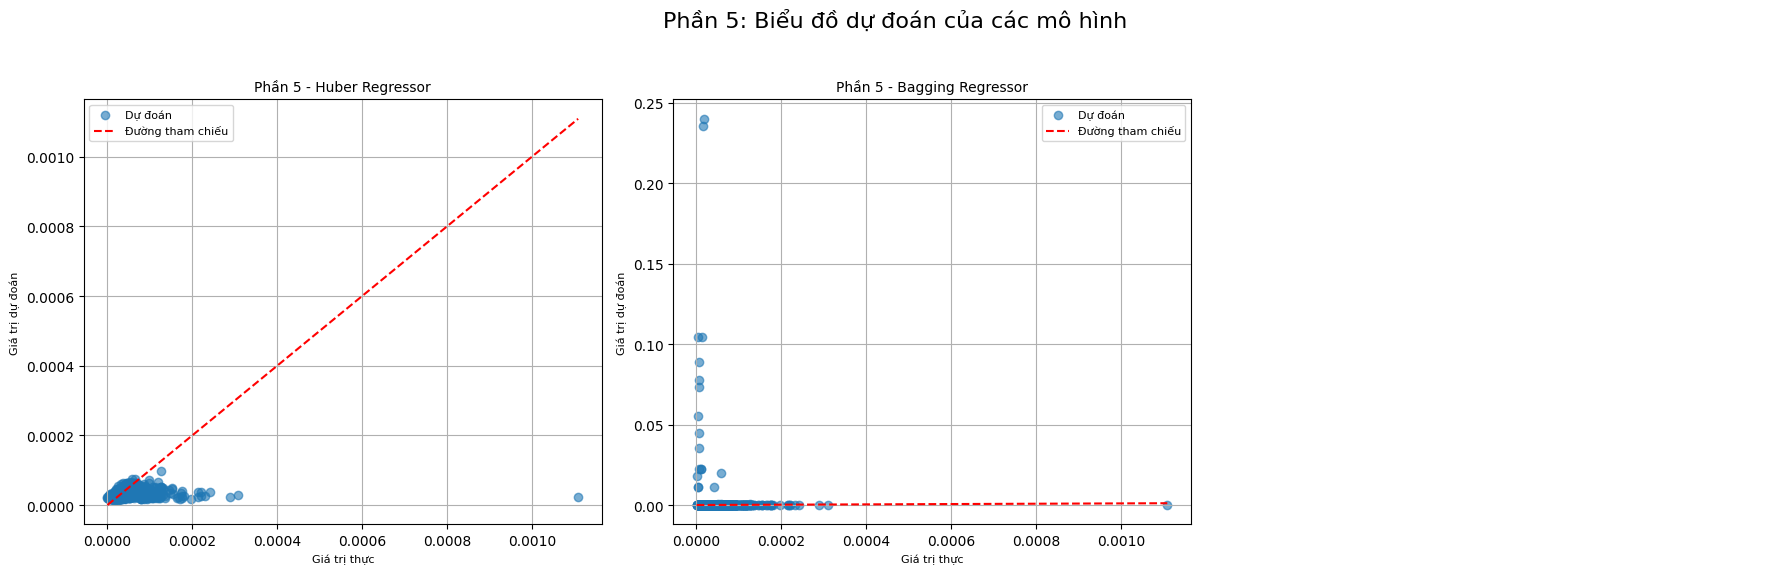

In [21]:
# Vẽ biểu đồ cho từng nhóm
print("Vẽ biểu đồ dự đoán (Phần 5):")
plot_predictions_grid(models_part_5, X_test, y_test, title_prefix="Phần 5")

Vẽ biểu đồ dự đoán (Phần 6):


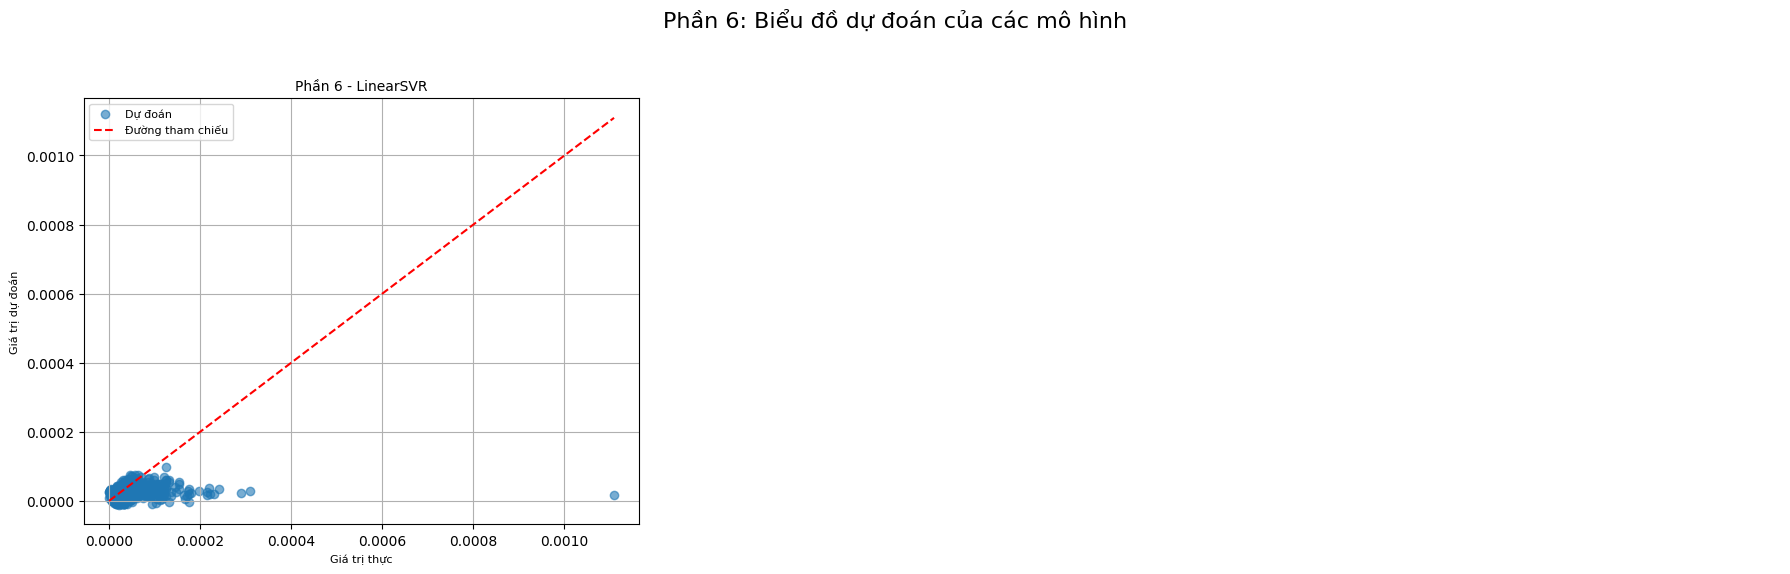

In [22]:
# Vẽ biểu đồ cho từng nhóm
print("Vẽ biểu đồ dự đoán (Phần 6):")
plot_predictions_grid(models_part_6, X_test, y_test, title_prefix="Phần 6")

Vẽ biểu đồ dự đoán (Phần 7):


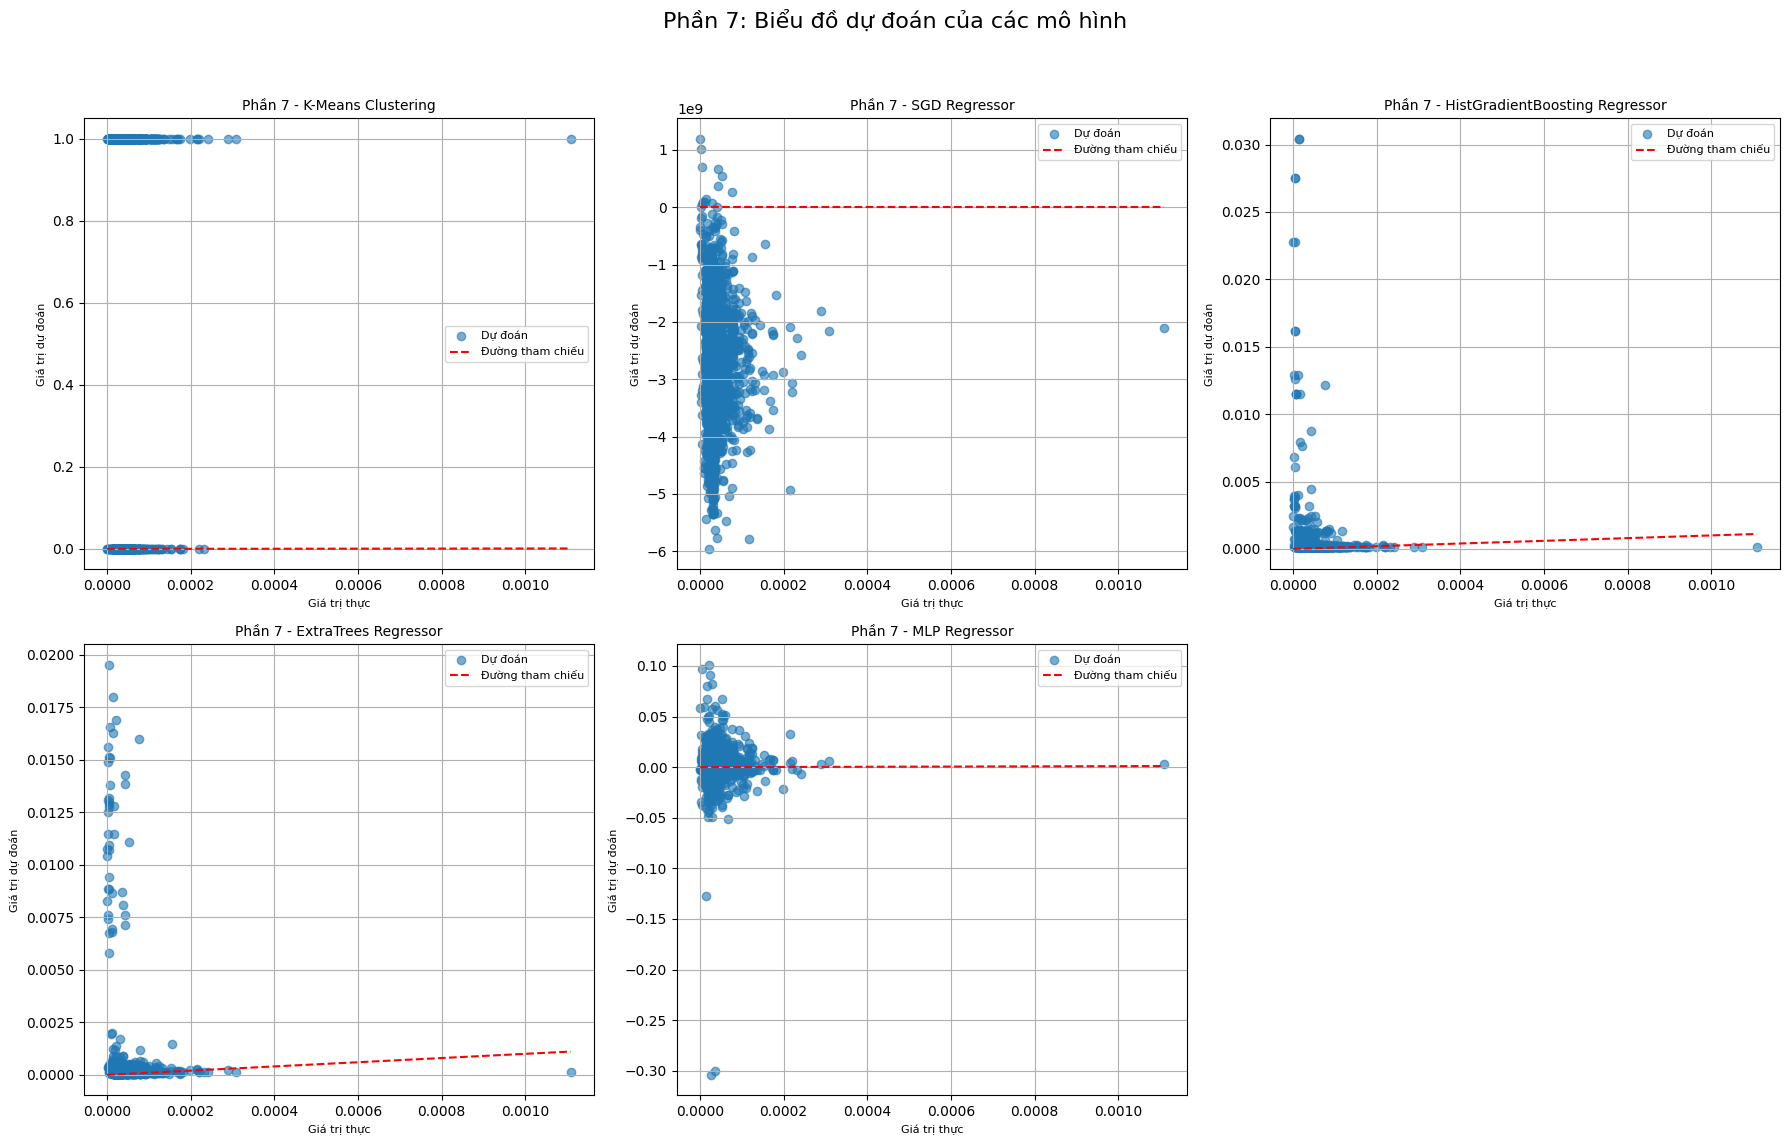

In [23]:
# Vẽ biểu đồ cho từng nhóm
print("Vẽ biểu đồ dự đoán (Phần 7):")
plot_predictions_grid(models_part_7, X_test, y_test, title_prefix="Phần 7")

Vẽ biểu đồ dự đoán (Phần 8):


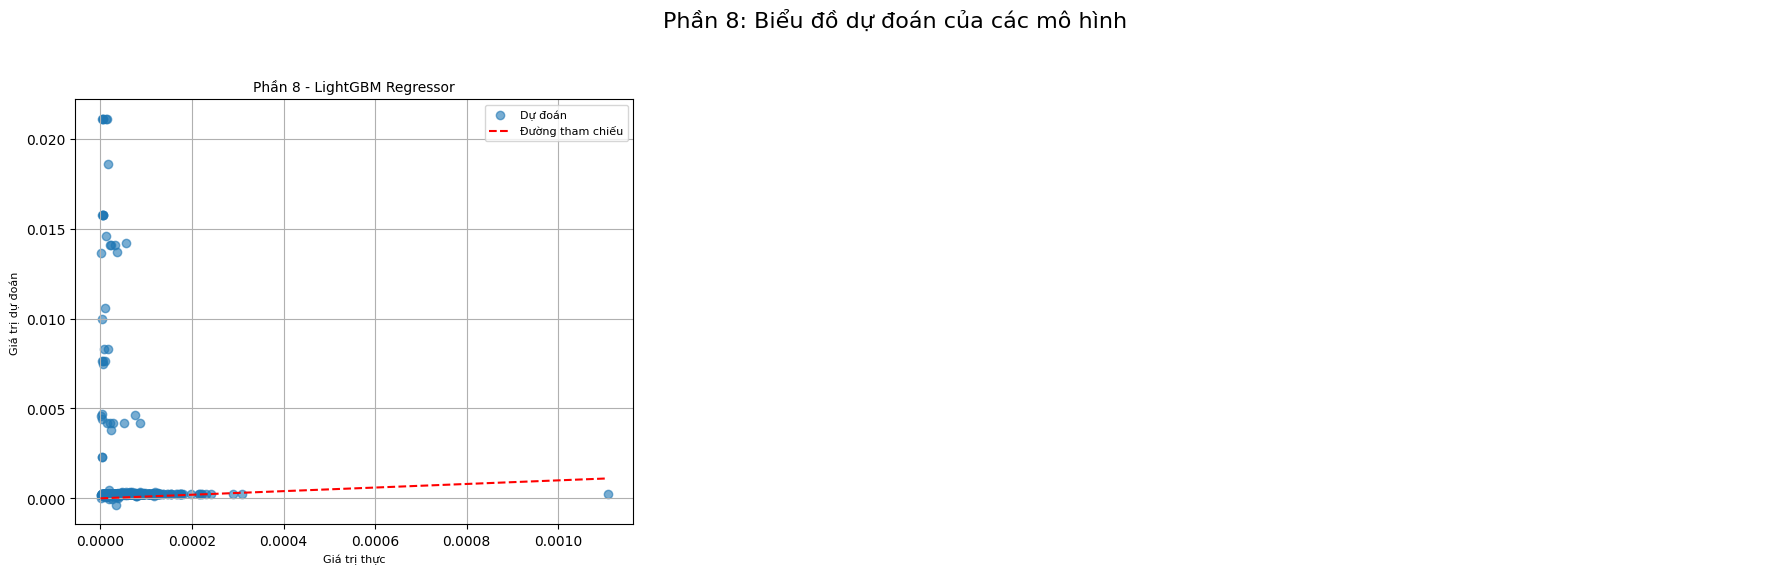

In [24]:
# Vẽ biểu đồ cho từng nhóm
print("Vẽ biểu đồ dự đoán (Phần 8):")
plot_predictions_grid(models_part_8, X_test, y_test, title_prefix="Phần 8")

Vẽ biểu đồ dự đoán (Phần 9):


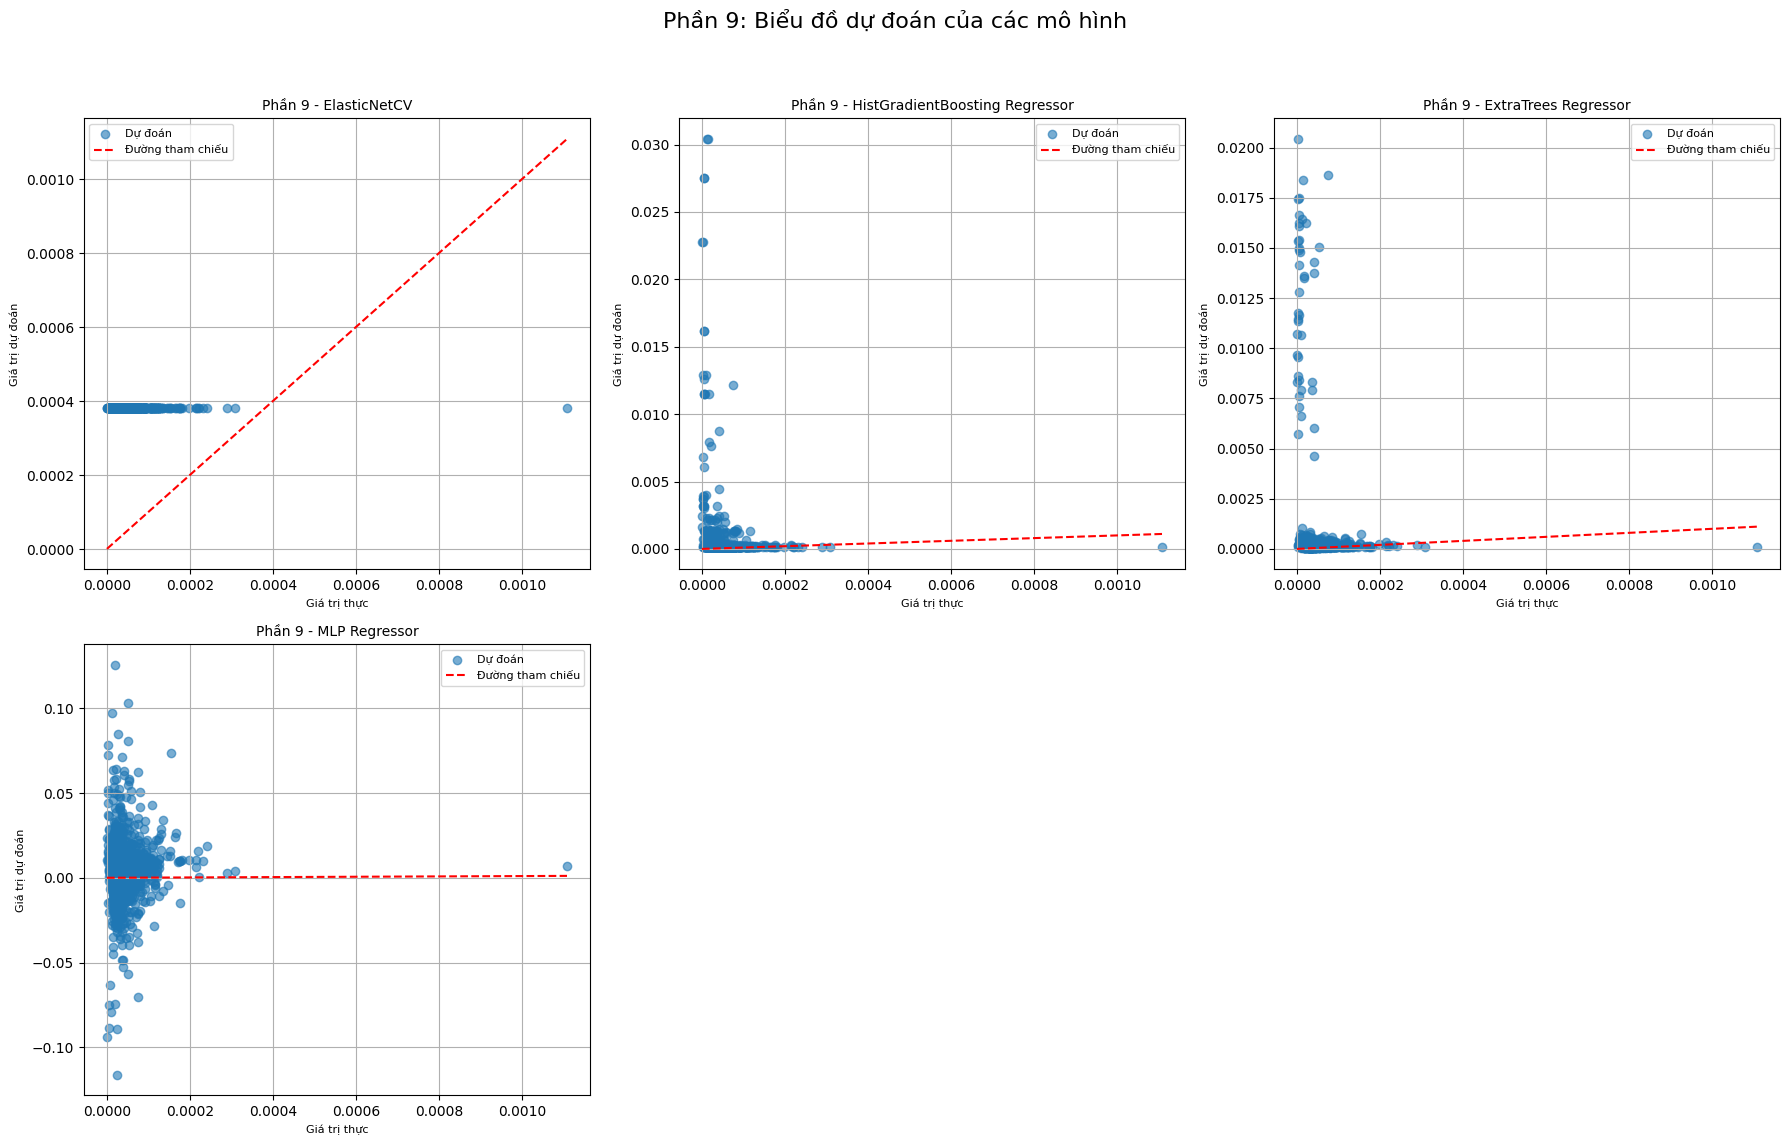

In [25]:
# Vẽ biểu đồ cho từng nhóm
print("Vẽ biểu đồ dự đoán (Phần 9):")
plot_predictions_grid(models_part_9, X_test, y_test, title_prefix="Phần 9")

Vẽ biểu đồ dự đoán (Phần 10):


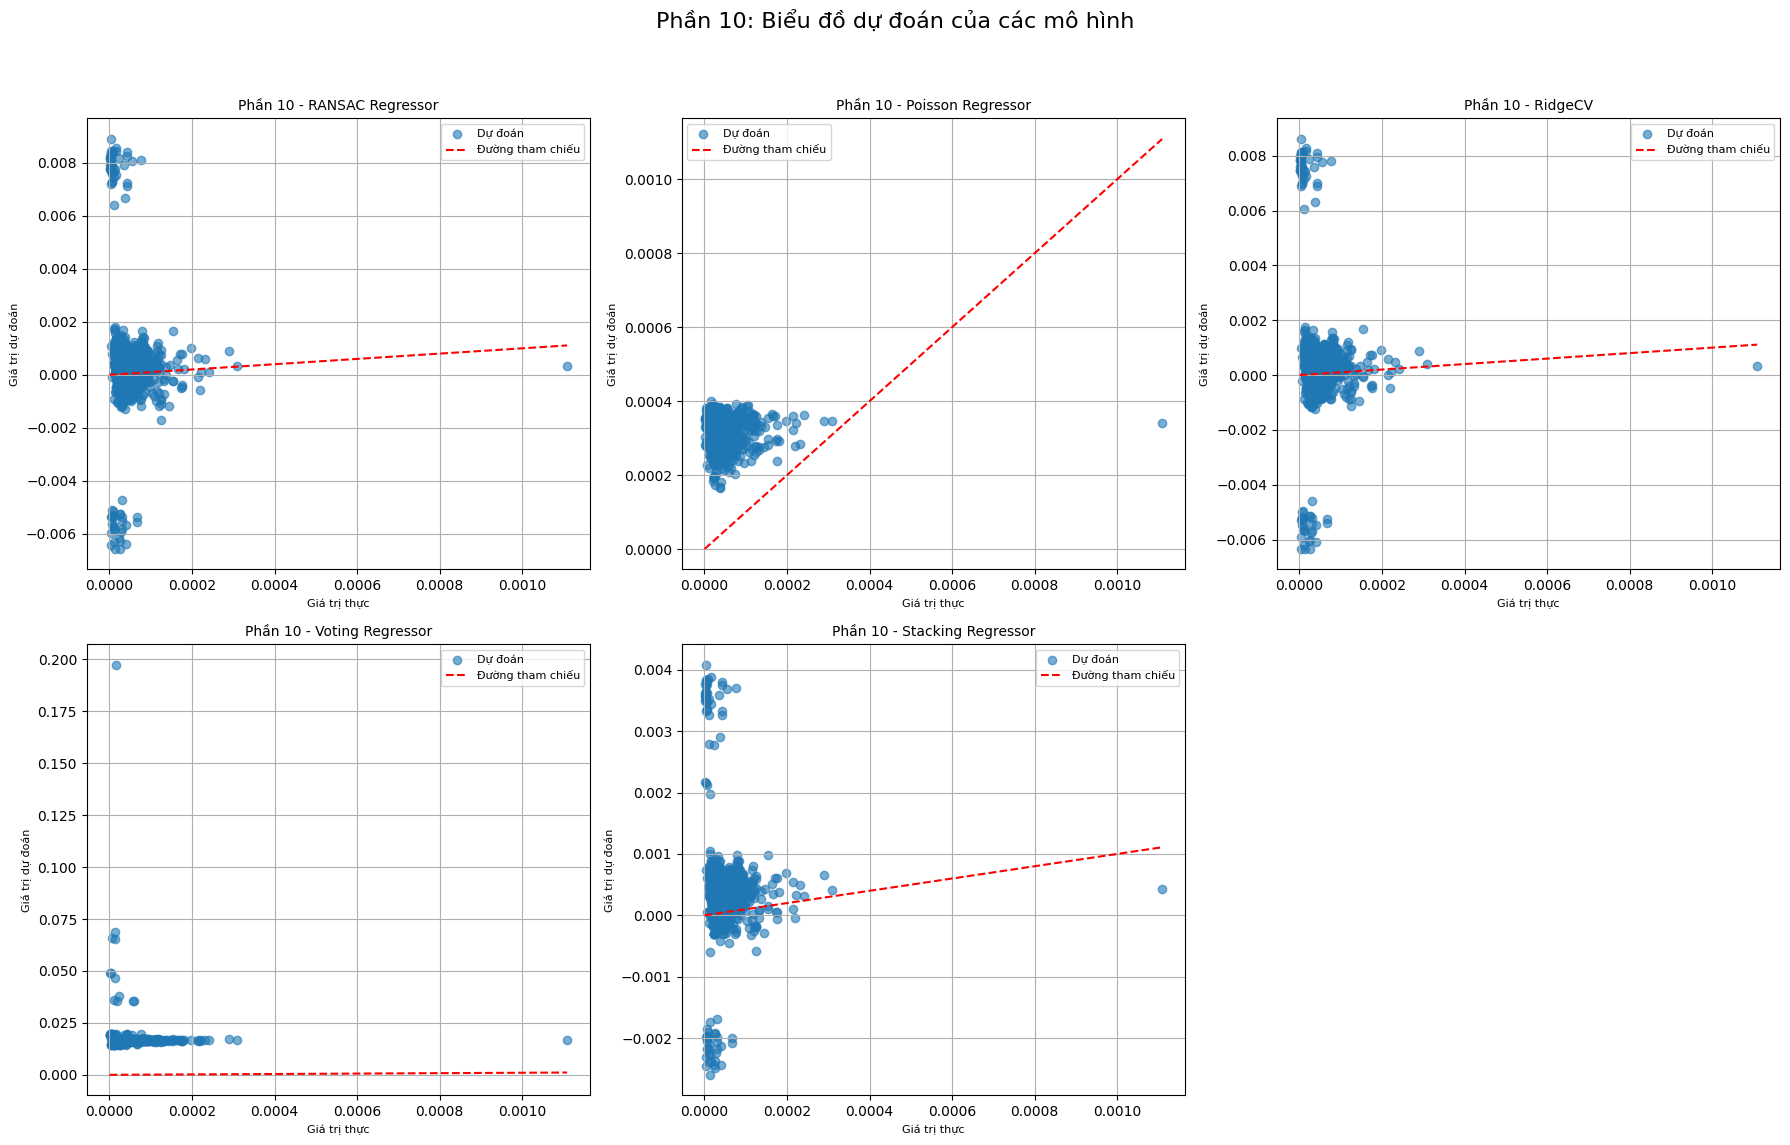

In [26]:
# Vẽ biểu đồ cho từng nhóm
print("Vẽ biểu đồ dự đoán (Phần 10):")
plot_predictions_grid(models_part_10, X_test, y_test, title_prefix="Phần 10")

In [27]:
all_results = {**model_results_part_1,**model_results_part_2,**model_results_part_3,**model_results_part_4,**model_results_part_5, **model_results_part_6, **model_results_part_7, **model_results_part_8, **model_results_part_9, **model_results_part_10}

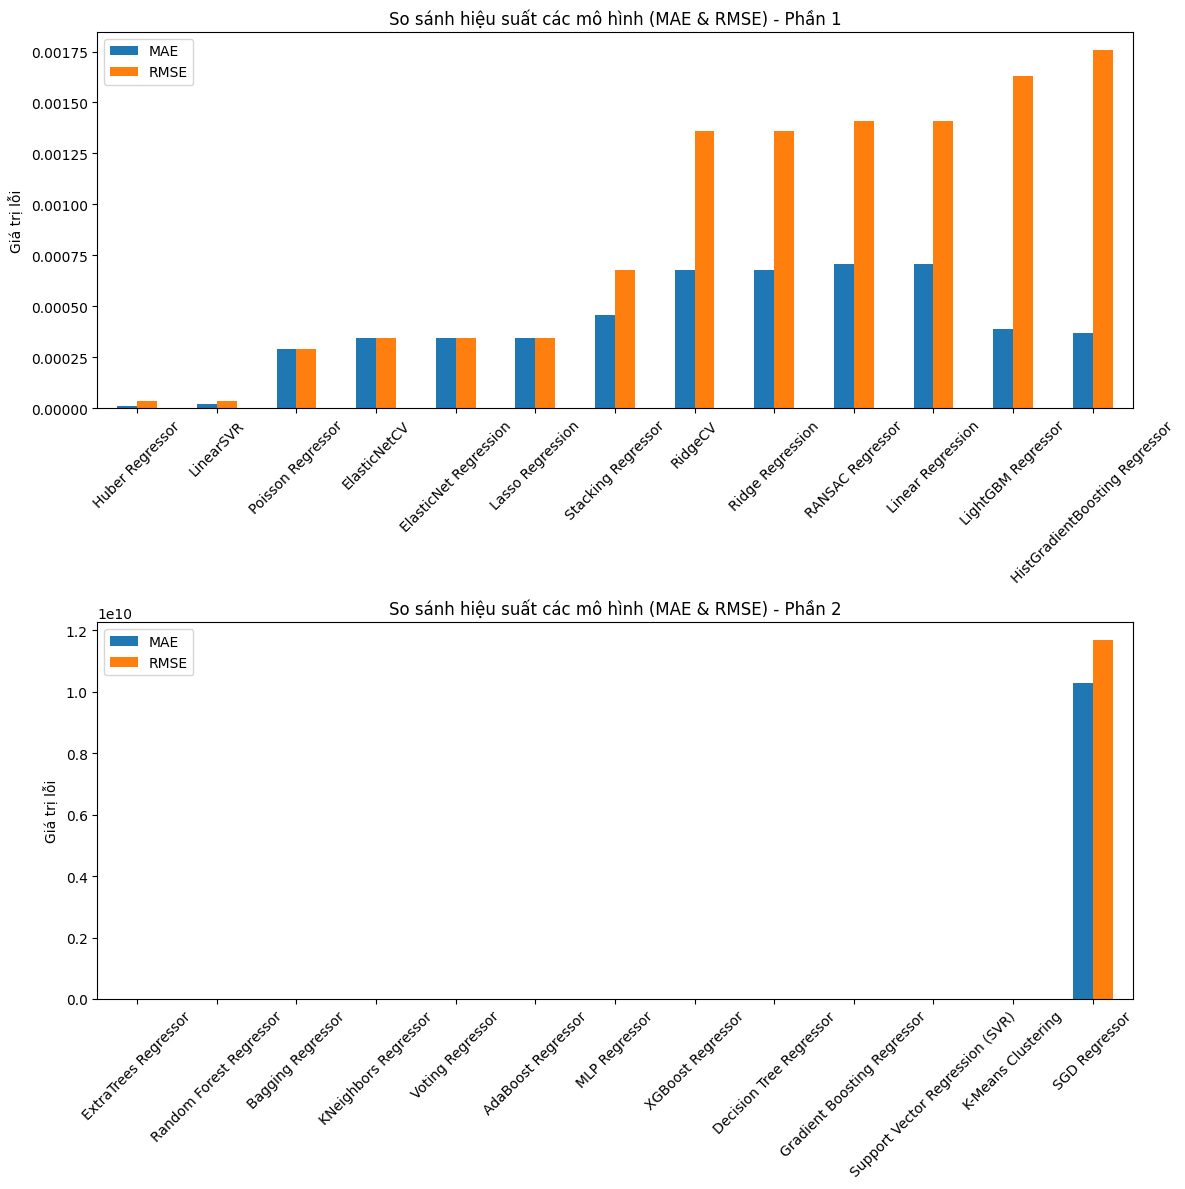

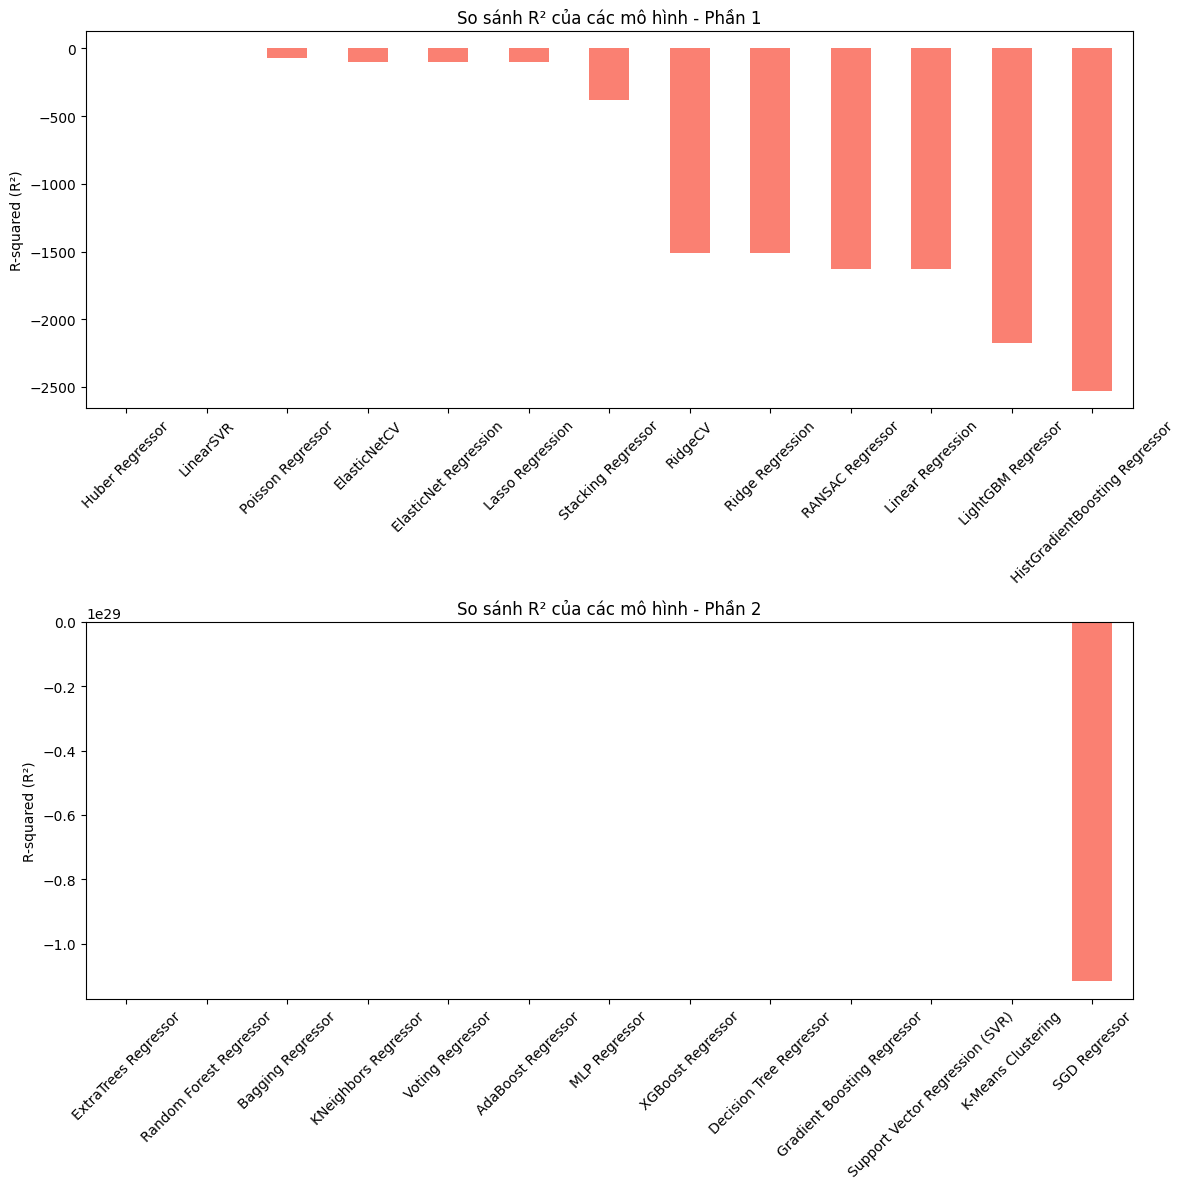


Kết quả hiệu suất mô hình (sorted by R²):
                                          MAE          RMSE            R²
Huber Regressor                  1.320766e-05  3.440837e-05  3.023810e-02
LinearSVR                        1.936864e-05  3.765310e-05 -1.612835e-01
Poisson Regressor                2.898802e-04  2.934944e-04 -6.955640e+01
ElasticNetCV                     3.446416e-04  3.457451e-04 -9.691492e+01
ElasticNet Regression            3.446416e-04  3.457451e-04 -9.691492e+01
Lasso Regression                 3.446416e-04  3.457451e-04 -9.691492e+01
Stacking Regressor               4.587410e-04  6.804776e-04 -3.782839e+02
RidgeCV                          6.780833e-04  1.359818e-03 -1.513602e+03
Ridge Regression                 6.780833e-04  1.359818e-03 -1.513602e+03
RANSAC Regressor                 7.064782e-04  1.409535e-03 -1.626377e+03
Linear Regression                7.064782e-04  1.409535e-03 -1.626377e+03
LightGBM Regressor               3.868452e-04  1.631045e-03 -2.178057

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Chuyển kết quả sang DataFrame để trực quan hóa
results_df = pd.DataFrame(all_results).T  # Chuyển vị để dễ đọc
results_df.sort_values(by="R²", ascending=False, inplace=True)  # Sắp xếp theo R²

# Tính số lượng mô hình cần vẽ
num_models = len(results_df)

# Chia thành hai phần (nếu số mô hình lớn hơn 10, ta sẽ chia thành 2 hàng)
split_index = num_models // 2

# Vẽ biểu đồ so sánh MAE và RMSE cho phần 1
plt.figure(figsize=(12, 12))  # Kích thước biểu đồ lớn hơn để chứa 2 hàng
plt.subplot(2, 1, 1)  # Vẽ phần đầu tiên của biểu đồ (hàng 1)
results_df[:split_index][["MAE", "RMSE"]].plot(kind="bar", ax=plt.gca())
plt.title("So sánh hiệu suất các mô hình (MAE & RMSE) - Phần 1")
plt.ylabel("Giá trị lỗi")
plt.xticks(rotation=45)
plt.legend(["MAE", "RMSE"])

# Vẽ biểu đồ so sánh MAE và RMSE cho phần 2
plt.subplot(2, 1, 2)  # Vẽ phần thứ hai của biểu đồ (hàng 2)
results_df[split_index:][["MAE", "RMSE"]].plot(kind="bar", ax=plt.gca())
plt.title("So sánh hiệu suất các mô hình (MAE & RMSE) - Phần 2")
plt.ylabel("Giá trị lỗi")
plt.xticks(rotation=45)
plt.legend(["MAE", "RMSE"])

plt.tight_layout()
plt.show()

# Vẽ biểu đồ R² cho phần 1
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)  # Vẽ phần đầu tiên của biểu đồ R²
results_df[:split_index]["R²"].plot(kind="bar", color='salmon', ax=plt.gca())
plt.title("So sánh R² của các mô hình - Phần 1")
plt.ylabel("R-squared (R²)")
plt.xticks(rotation=45)

# Vẽ biểu đồ R² cho phần 2
plt.subplot(2, 1, 2)  # Vẽ phần thứ hai của biểu đồ R²
results_df[split_index:]["R²"].plot(kind="bar", color='salmon', ax=plt.gca())
plt.title("So sánh R² của các mô hình - Phần 2")
plt.ylabel("R-squared (R²)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# In kết quả
print("\nKết quả hiệu suất mô hình (sorted by R²):")
print(results_df)